<a id='top'></a>

# CSCI 3202: Intro to AI - Fall 2020 Practicum 2

## Your name: Kelley Kelley

#### Collaborator's name (optional): me, myself, and I


---
**Shortcuts:**  [Problem 1: Search](#p1) | [Problem 2: MDP](#p2) | [Problem 3: Q_Learn](#bot)

---

This practicum is due on Canvas by **10:00 PM on Saturday December 12**. Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  

**Here are the rules:** 

1. All work, code and analysis, must be your own. 
2. You may use your course notes, posted lecture slides, textbooks, in-class notebooks, and homework solutions as resources.  You may also search online for answers to general knowledge questions like the form of a probability distributions or how to perform a particular operation in Python/Pandas. 
3. This is meant to be like a coding portion of your final exam. So, the instructional team will be much less helpful than we typically are with homework. For example, we will not check answers, help debug your code, and so on.
4. If something is left open-ended, it is because we want to see how you approach the kinds of problems you will encounter in the wild, where it will not always be clear what sort of tests/methods should be applied. Feel free to ask clarifying questions though.
5. You may **NOT** post to message boards or other online resources asking for help.  If you have a question for us, post it as a **PRIVATE** message on Piazza.  If we decide that the question is appropriate for the entire class, then we will add it to a Practicum clarifications thread. 
6. You may re-use your code or code given from in-class solutions (for e.g. Astar, MDP), but you **must cite** in comments any regions of code that were not created anew for this practicum.
7. You may collaborate with **exactly one** of your classmates.  You must each submit your own assignments and write your own code, and may only collaborate on ideas, psuedocode, etc.  If you choose to collaborate with another student in the class, list their name under yours above.
8. In short, **your work must be your own**. It really is that simple.

Violation of the above rules will result in an immediate academic sanction (*at the very least*, you will receive a 0 on this practicum or an F in the course, depending on severity), and a trip to the Honor Code Council.

**By submitting this assignment, you agree to abide by the rules given above.**

***

**NOTES**: 

- You may not use late days on the practicums nor can you drop your practicum grades.
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.
***


In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors


Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 


In [2]:
#Some tuples defining the wall and state locations, for your convenience

walls = [(1,y) for y in range(2,15)] + [(2,y) for y in range(3,14)] + [(3,y) for y in range(4,13)] + \
        [(4,y) for y in range(5,12)] + [(x,1) for x in range(5,24)] + [(10,y) for y in range(9,13)] + \
        [(x,y) for x in range(11,14) for y in range(9,15)] + [(14,y) for y in range(11,15)] + \
        [(x,y) for x in range(21,26) for y in range(11,17)] + \
        [(x,y) for x in [0,26] for y in range(0,18)] + [(x,y) for x in range(0,26) for y in [0,17]]
        
states = [(x,y) for x in range(1,26) for y in range(1,17)]

# I'm adding goal and start bc easy and useful, added big in front
macro_goal = (25, 9)
macro_start = (1, 15)

[Back to top](#top)
<a id='p1'></a>


---
## [40 pts] Part 1:  Route-finding
In this problem, our goal is to find the path from the green to yellow squares with the **shortest total path length**.

Of course, you can probably do this problem (and likely have to some degree, in your head) without a search algorithm. But that will hopefully provide a useful "sanity check" for your answer.

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you.

Print to the screen the output for `adjacent_states((1,15))`.

In [3]:
# Your adjacency here
def adjacent_states(cord):
    # this is placeholder for what we return
    adjacents = []
    # storing cord in a more useful/easy way to use
    x = cord[0]
    y = cord[1]
    # every possible action we could take ignoring walls and edges
    possibles = [(x+1, y), (x, y-1), (x, y+1), (x-1, y) ]
    # now we filter walls and edges by simply saying if
    # it's a wall don't append it or if its not in our state
    # space don't append it
    for possible in possibles:
        if not possible in walls and possible in states:
            adjacents.append((possible, 1))
    # do diagonals in same way but seperately bc lifes just easy that way
    possibles = [(x+1, y+1), (x+1, y-1), (x-1, y+1), (x-1, y-1)]
    for possible in possibles:
        if not possible in walls and possible in states:
            adjacents.append((possible, 2**0.5))
    return adjacents
    
print(adjacent_states((1,15)))
# yay it works cool

[((2, 15), 1), ((1, 16), 1), ((2, 16), 1.4142135623730951), ((2, 14), 1.4142135623730951)]


#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [4]:
# cool thing about everyhting costing 1 and diagonals costing what they should,
# these heuristics are super straight forward
# just take the x's and y's and do the maths
def heuristic_cols(state, goal):
    return abs(state[1] - goal[1])
    
def heuristic_rows(state, goal):
    return abs(state[0] - goal[0])
    
def heuristic_eucl(state, goal):
    return ((state[0]-goal[0])**2 + (state[1] - goal[1])**2)**.5
    
# also easy, just max of the function calls on state goal
def heuristic_max(state, goal):
    return max(heuristic_cols(state, goal), 
               heuristic_rows(state, goal),
               heuristic_eucl(state, goal))

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not.

**Answer here**
Yes because we can move diagonally which means Manhattan distance is pretty roundabout and will often be an overestimate that provides nothing really useful to us. 

#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A, similarly to the 8-tile problem from Homework 3. 

In [5]:
#Astar soln:
# Frontier class is just way too useful from HW3 and practicum1 so rip
#ctrl+v
class Frontier_PQ:
    
    # initialize states and q in the frontier class
    # states are explored q is the sorted list of current possible paths
    def __init__(self, start, cost):
        self.states = {start:cost}
        self.q = []
    
    # add a possible path to our sorted heap / the frontier
    def add(self, state, cost):
        # since we can't use heapq its a list that we just sort on the first element in the tuple
        self.q.append((cost, state))
        self.q.sort(key = lambda x: x[0])
    
    # move from our frontier to our explored and return the lowest element
    # from our frontier
    def pop(self):
        # since we can't use heapq its a list that we just sort on the first element in the tuple
        lowest = self.q[0]
        self.q = self.q[1:]
        self.states[lowest[1]] = lowest[0]
        return lowest
    
    # replace a frontier path with a better path
    # I also return True or False because this will make
    # UCS easier 
    def replace(self, state, cost):
        for i in range(0, len(self.q)):
            if self.q[i][1] == state:
                # make sure the path is actually better
                if self.q[i][0] > cost:
                    # since we can't use heapq its a list that we just sort on the first element in the tuple
                    self.q[i] = (cost, state)
                    self.q.sort(key = lambda x: x[0])
                    return True
                else:
                    return False
    
    # just a helper function for testing frontier class
    def test(self):
        print(self.states, self.q)
        
# also ripping path bc dang, that is such a useful function
def path(previous, s): 
    '''
    `previous` is a dictionary chaining together the predecessor state that led to each state
    `s` will be None for the initial state
    otherwise, start from the last state `s` and recursively trace `previous` back to the initial state,
    constructing a list of states visited as we go
    '''
    if s is None:
        return []
    else:
        return path(previous, previous[s])+[s]

In [6]:
# Cells just make stuff cleaner and easier so new cell
# kind of copied from practicum but format is different and 
# so its not really a copy more like plaigarising myself
def astar_search():
    #initialize frontier
    frontier = Frontier_PQ(macro_start, 0)
    # initialize path
    notpath = {macro_start:None}
    # get the nodes next to our starting node
    for node in adjacent_states(macro_start):
        # node is tuple well first element is next state second is cost
        frontier.add(node[0], node[1] + heuristic_max(macro_start, macro_goal))
        notpath[node[0]] = macro_start
    # do this until we find goal
    while True:
        # get the closest thing
        node_tuple = frontier.pop()
        # yay we found the goal
        if node_tuple[1] == macro_goal:
            truepath = path(notpath, macro_goal)
            return truepath
        # now we have new possibilities add them
        for node in adjacent_states(node_tuple[1]):
            # if we've found shortest path to our node skip it
            if not node[0] in frontier.states:
                # now check if we need to replace node or add it
                if not node[0] in notpath:
                    # not in path so add
                    frontier.add(node[0], node_tuple[0] + node[1] + heuristic_max(node[0], macro_goal))
                    notpath[node[0]] = node_tuple[1]
                # ok, now replace/try to and if better replace in path if not ignore it's exsistence
                elif frontier.replace(node[0], node_tuple[0] + node[1] + heuristic_max(node[0], macro_goal)):
                    notpath[node[0]] = node_tuple[1]

final_path = astar_search()
print(final_path)

[(1, 15), (2, 14), (3, 13), (4, 12), (5, 11), (6, 10), (7, 9), (8, 9), (9, 9), (10, 8), (11, 8), (12, 8), (13, 8), (14, 9), (15, 9), (16, 9), (17, 9), (18, 9), (19, 9), (20, 9), (21, 9), (22, 9), (23, 9), (24, 9), (25, 9)]



#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

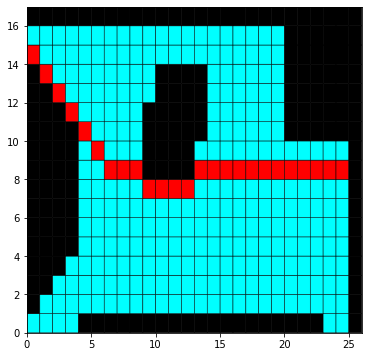

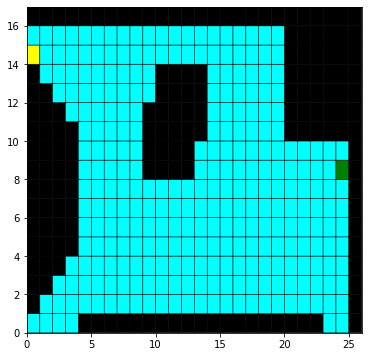

In [7]:
# first make the 'maze' for us to print
maze = [[0 for i in range(26)] for j in range(17)]
# everything is 0 to start
for x in range(len(maze)):
    for y in range(len(maze[x])):
        maze[x][y] = 0
# now update the maze with our path
for cord in final_path:
    maze[cord[1]-1][cord[0]-1] = 1
# do walls last, if our path is suddenly missing
# then we know we tried to go through walls and failed somehow
for cord in walls:
    maze[cord[1]-1][cord[0]-1] = 2
cmap = colors.ListedColormap(['Cyan', 'Red', 'Black'])
plt.figure(figsize=(6,6))
plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=0.5)
plt.show()
# the original without the path for comparison
# first make the 'maze' for us to print
maze = [[0 for i in range(26)] for j in range(17)]
# everything is 0 to start
for x in range(len(maze)):
    for y in range(len(maze[x])):
        maze[x][y] = 0
# do walls last, if our path is suddenly missing
# then we know we tried to go through walls and failed somehow
for cord in walls:
    maze[cord[1]-1][cord[0]-1] = 1
# add our start and end bc cool
maze[macro_start[1]-1][macro_start[0]-1] = 2
maze[macro_goal[1]-1][macro_goal[0]-1] = 3
cmap = colors.ListedColormap(['Cyan', 'Black', 'Yellow', 'Green'])
plt.figure(figsize=(6,6))
plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=0.5)
plt.show()

[Back to top](#top)
<a id='p2'></a>


---
## [40 pts] Part 2:  States and Values

Winter has come, and now the area west of Engineering is icy and slippery.  As a result, there's a risk that we don't end up in the tile that we intend to move to!  In particular, if we have $k$ available actions in state $n$, the probably that we move to the state $s'$ we intend to is 75\%, and the remaining 0.25 probability is spread equally likely across all of the other adjacent (N/S/E/W/NW/NE/SE/SW) non-wall states.

In this problem, our goal is to create a policy for an agent walking in the given space west of Engineering.  Again, the goal of the agent is to navigate from start to finish, but now we want a policy for each and every location on the map.

This time, however, we're going to add the same type of randomness that our process in homework 4 had.

Because the state space is fully observable, we should be able to implement this as a Markov Decision process.


#### Part A:

Write the necessary functions to create *either* a **value iteration** or **policy iteration** scheme to solve for the MDP.  If you wish to follow the schema for homework 4, you may want to create an `MDP` class, with methods:

- `actions`, given by the valid successor states $s'$ from all actions $a$ in state $s$ in your adjacent_states from part 1.
- `rewards`, given by a significant positive reward for the goal state (e.g. 10) and a small negative reward for spending a long time in the system (e.g. non-wall reward of -0.01).
- `result`, which returns the successor state $s'$ of an *actual* movement $a$ from state $s$.
- `transition`, which returns the probability of an actual successor $s'$ given action $a$ from state $s$ using the 75\%-25% split above.


In [8]:
# I'm going to copy HW4, except not really since I have to change stuff
# for it to work, but I'm basically copying
class MDP:
    def __init__(self, nrow, ncol, terminal, discount):
        '''Create/store the following attributes:
        states -- list of all the states (x,y) tuples
        terminal_states -- is a dictionary with terminal state keys, and rewards as values
        default_reward -- is the reward for being in any non-terminal state
        df -- discount factor
        ... and anything else you decide will be useful!
        '''
        
        self.nrow = nrow
        self.ncol = ncol
        #self.states = [(x,y) for x in range(1,ncol+1) for y in range(1,nrow+1)]
        # we have a list of states already so
        self.states = states
        self.terminal_states = terminal
        self.df = discount   
    
    def actions(self, cord):
        # copy paste adjacent_states from before but don't return pathcost
        # this is placeholder for what we return
        adjacents = []
        # storing cord in a more useful/easy way to use
        x = cord[0]
        y = cord[1]
        # every possible action we could take ignoring walls and edges
        possibles = [[(x+1, y), 'E'], [(x, y-1), 'S'], 
                     [(x, y+1), 'N'], [(x-1, y), 'W'],
                     [(x+1, y+1), 'NE'], [(x+1, y-1), 'SE'], 
                     [(x-1, y+1), 'NW'], [(x-1, y-1), 'SW']]
        # now we filter walls and edges by simply saying if
        # it's a wall don't append it or if its not in our state
        # space don't append it
        for possible in possibles:
            if not possible[0] in walls and possible[0] in states:
                adjacents.append(possible[1])
        return adjacents
    
    def rewards(self, cord):
        # reward for terminal states is 10 bc we only have goals in 
        # terminal
        if cord in self.terminal_states or cord == self.terminal_states:
            return 10
        # everything else -0.01 so we actually want to get out fast
        else:
            return -0.01
        
    def result(self, cord, action):
        assert action in self.actions(cord), 'Error: non valid action in result'
        assert cord in self.states, 'Error: invalid state in result'
        # split into x and y bc easier to work with
        new_x = cord[0]
        new_y = cord[1]
        # actions can have N/E/S/W and multiple actions, if you just check
        # and see if say N is in our action then add 1 to y, ie NE becomes
        # if N add one if E add one so on, just simple way of doing this
        if 'N' in action:
            new_y += 1
        if 'S' in action:
            new_y -= 1
        if 'W' in action:
            new_x -= 1
        if 'E' in action:
            new_x += 1
        return (new_x, new_y)
    
    # transition, imma copy this from hw4
    def transition(self, cord, action):
        if action is None:
            return[(0, cord)]
        else:
            assert action in self.actions(cord), 'Error: not valid action from state'
            assert cord in self.states, 'Error: invalid state in transition'
            # storing for return
            transitions = []
            # append our first probability
            transitions.append((0.75, self.result(cord, action)))
            # probability of other actions
            # -1 since we don't want to include the action we are actually trying to take
            # but then +1 bc none action so net 0
            probability = 0.25/len(self.actions(cord))
            transitions.append((probability, cord))
            for possible_action in self.actions(cord):
                # skip over action we tried
                if not action == possible_action:
                    transitions.append((probability, self.result(cord, possible_action)))
            return transitions
            
# testing to make sure it works      
#mdp = MDP(16, 25, macro_goal, 1)
#print(mdp.actions((1,15)))
#print(mdp.actions((12, 11)))
#print(mdp.actions((1,15)))
#print(mdp.result((1,15), 'NE'))
#print(mdp.result((1,15), 'SE'))
#print(mdp.result((1,15), 'W'))
#print(mdp.actions((5,5)))
#print(mdp.result((5,5), 'SW'))
#print(mdp.transition((1,15), 'SE'))
#one = 0
#for thing in mdp.transition((1,15), 'SE'):
#    one += thing[0]
#print(one)
# cool yay it works


#### Part B:

Using the MDP in part 2A, implement value iteration **or** policy iteration to calculate the utilities for each state. Also implement a function that takes as arguments an MDP object and a dictionary of state-utility pairs (key-value) and returns a dictionary for the optimal policy. The optimal policy dictionary should have state tuples as keys and the optimal move (None or any of the 8 directions) as values.

In [9]:
# Copying HW4 and making minor adjustments where necessary
# wait, I can't find what the discount factor should be???
# I'm going to make it 0.8 because it's cold and I want to get to the
# engineering center fast, much more value in getting there immediately
discount_factor = 0.8
# this function returns utility for every state 
def value_iteration(mdp, tol=1e-3):
    # initialize utilitiy
    utility = {}
    for s in mdp.states:
        # but we need to skip over walls since they aren't techincally states
        if not s in walls:
            utility[s] = mdp.rewards(s)
    # iterate
    while True:
        # copy current utility estimate
        util_copy = utility.copy()
        # initialize max change
        max_change = 0
        # iterate through states
        for s in mdp.states:
            # skip walls they don't exist, and the goal shouldn't be updating oops, I messed
            # that up in hw4
            if not s in walls and not s == macro_goal:
                # get transitions
                next_states = [mdp.transition(s, a) for a in mdp.actions(s)]
                # calc
                best_utility = float('-inf')
                # iterate
                for transitions in next_states:
                    # sum
                    newsum = sum([transition[0]*util_copy[transition[1]] for transition in transitions])
                    best_utility = max(best_utility, newsum)
                    if len(next_states) == 1:
                        best_utility = newsum
                # update utility
                utility[s] = mdp.rewards(s) + mdp.df*best_utility
                # update max change
                max_change = max(max_change, abs(util_copy[s] - utility[s]))
        # if max change less than tolerance we done
        if (mdp.df == 1 and max_change < tol) or max_change < tol*(1-mdp.df)/mdp.df:
            return utility
            
# this function returns optimal policy for each state
def find_policy(mdp, utility):
    # intialize dictionary of policies for each state to None
    policy = {s : None for s in mdp.states}
    # loop over every state
    for state in mdp.states:
        # skip walls they don't exist, well, pretend they don't
        if not state in walls:
            # intialize best utility to -inf
            best_utility = (float('-inf'), None)
            # loop over actions
            for action in mdp.actions(state):
                #calculate expected utility of action
                newsum = sum([p*utility[s] for p, s in mdp.transition(state, action)])
                # if expected utility is better update best utility
                if newsum > best_utility[0]:
                    best_utility = (newsum, action)
            # update policy for this state to best utility
            policy[state] = best_utility[1]
    # return policy
    return policy

icy_mdp = MDP(16, 25, macro_goal, discount_factor)
utility = value_iteration(icy_mdp)
# so slight issue, walls have a value of -inf, oops, fixed
policy = find_policy(icy_mdp, utility)


#### Part C:

Sanity check your answers in part B by listing which state has the *lowest* estimated utility (should be far from the goal!) and which states have the 3 *highest* estimated utilities.

In [10]:
# ok, after a few issues with walls and the goal not existing bc I'm bad at python, it looks like it works
# make a list of utilities
sorted_utils = []
for util in utility.keys():
    sorted_utils.append((utility[util], util))
# sort the list
sorted_utils.sort(key = lambda x: x[0])
# print some stuff
print('lowest utility:', sorted_utils[0])
print('highest utility:', sorted_utils[-4:-1])
print('goal utility:', sorted_utils[-1])

lowest utility: (-0.04070015298264549, (1, 16))
highest utility: [(7.308434235158666, (24, 10)), (7.3114091229740925, (24, 9)), (7.462131668436871, (25, 10))]
goal utility: (10, (25, 9))



#### Part D:

As in part 1E, make a figure.  This time, depict the optimal policy at each location.  Your choice of visualization is up to you, but I would *recommend* taking a plot similar to the maze plot in Part 1E above (or HW 2) and plotting some choice of arrows/symbols/colors corresponding to the appropriate action in each square.

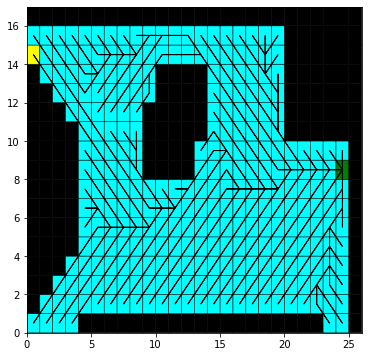

In [11]:
# the original without the path for comparison
# first make the 'maze' for us to print
maze = [[0 for i in range(26)] for j in range(17)]
# everything is 0 to start
for x in range(len(maze)):
    for y in range(len(maze[x])):
        maze[x][y] = 0
# do walls last, if our path is suddenly missing
# then we know we tried to go through walls and failed somehow
for cord in walls:
    maze[cord[1]-1][cord[0]-1] = 1

# add our start and end bc cool
maze[macro_start[1]-1][macro_start[0]-1] = 2
maze[macro_goal[1]-1][macro_goal[0]-1] = 3
cmap = colors.ListedColormap(['Cyan', 'Black', 'Yellow', 'Green'])
plt.figure(figsize=(6,6))
plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=0.5)
# yeah, this is going to be interesting
for pol in policy.keys():
    if policy[pol] == 'NE':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, 1, 1)
    if policy[pol] == 'NW':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, -1, 1)
    if policy[pol] == 'SE':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, 1, -1)
    if policy[pol] == 'SW':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, -1, -1)
    if policy[pol] == 'N':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, 0, 1)
    if policy[pol] == 'W':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, -1, 0)
    if policy[pol] == 'S':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, 0, -1)
    if policy[pol] == 'E':
        plt.arrow(pol[0]-0.5, pol[1]-0.5, 1, 0)
plt.show() 
# WOOOOOAAAHHHHHHHH
# that looks so cool

[Back to top](#top)
<a id='p3'></a>


---
## [20 pts] Part 3:  The great unknown

It's nearly winter solstice, and the area west of Engineering is still icy and slippery.  

As a result, there's still a risk that we don't end up in the tile that we intend to move to!  Unfortunately, for this problem we *don't know* what that risk is, and it isn't the same everywhere.  As in Problem 2, our goal is to create a policy for an agent walking in the given space west of Engineering.  Again, the goal of the agent is to navigate from start to finish, but now we want a policy for each and every location on the map

Suppose there exists some function $f$ that measures the *footing* of state $s$.  Then if we choose to take the action "move towards state $s'$" from state $n$, the probability that we *actually arrive* in the state $s'$ we intend to is $f(s)$.  As before, the remaining $1-f(s)$ probability is spread equally likely across all of the other adjacent (N/S/E/W/NW/NE/SE/SW) non-wall states to $s$.

Because our agent can't fully observe the transitions, it's going to have to pick actions and estimate their utilities from learning.  Let's use Q-learning!

#### Part A:

Run the following code to provide a function for and a map of the footing function $f$.


Text(0.5, 1.0, 'Footing')

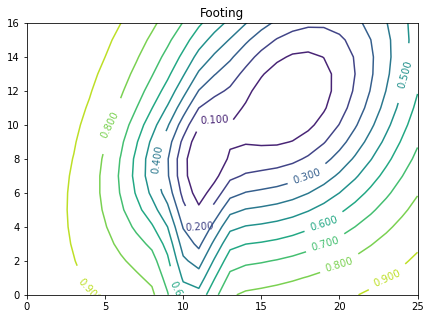

In [12]:
###YOU MAY IGNORE THIS CELL, BUT MUST RUN IT TO GENERATE F
random.seed(30)
x = np.linspace(0,25,26)
y = np.linspace(0,25,26)
X,Y = np.meshgrid(x,y)
f1 = np.zeros(X.shape)
f2 = np.zeros(X.shape)
f3 = np.zeros(X.shape)
f4 = np.zeros(X.shape)

mu1, mu2, mu3, mu4 = [17,12],[17,11],[11,8],[11,6]
covar1, covar2, covar3, covar4= [[16,8],[8,16]],[[12,.5],[.5,12]],[[4,.8],[.8,4]],[[.8,12],[.8,12]]
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        f1[i,j] = 6*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu1, cov=covar1)
        f2[i,j] = 3*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu2, cov=covar2)
        f3[i,j] = stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu3, cov=covar3)
        f4[i,j] = 1*stats.multivariate_normal.pdf(x=(X[i,j],Y[i,j]), mean=mu4, cov=covar4)
        
f =f1+f2+f3+f4    
f=1-(f/np.max(f))**(1/3)

#PLOTTING:
fig, ax = plt.subplots(1,1, figsize=(7,5))
my_levels = np.linspace(0, 1, 11)
labels = [str(lv) for lv in my_levels]
cp = ax.contour(X, Y, f, levels=my_levels)
plt.clabel(cp, inline=1, fontsize=10)
ax.set(xlim=(0, 25), ylim=(0, 16))
plt.title('Footing')


In [13]:

# You can access f directly using indices if you use the TRANPOSE of the coordinates of each point
#which this footing function does
def footing(x,y):
    return f[y,x]

print("It's icy at (12,8), with almost no footing:", footing(12,8))
print("It's better at (8,12):", footing(8,12))

It's icy at (12,8), with almost no footing: 0.0344326686812465
It's better at (8,12): 0.6595232752211774


#### Part B:

We're going to implement Q-learning instead of an MDP.

You will probably want to create a dictionary of the form discussed at the end of the in-class notebook for Q-learning, where each valid tuple is the first key and each valid move from that location is the second key.  You then should have the estimated utilities of each action saved in the resulting dictionary.  You may include other information if desired, but nothing else should be absolutely necessary.

After initialization, print the elements of the dictionary corresponding to the (4,4) location.  Note that there should be 7 subdictionaries for the 6 possible neighbors and the `None` action, and within each action the initial Q-value should be zero.

In [14]:
#create a Q, initialize all the Q-utilities as 0.
Q = {}

# for making this its useful to copy our actions funciton
def actions(cord):
        # copy paste adjacent_states from before but don't return pathcost
        # this is placeholder for what we return
        adjacents = []
        # storing cord in a more useful/easy way to use
        x = cord[0]
        y = cord[1]
        # every possible action we could take ignoring walls and edges
        possibles = [[(x+1, y), 'E'], [(x, y-1), 'S'], 
                     [(x, y+1), 'N'], [(x-1, y), 'W'],
                     [(x+1, y+1), 'NE'], [(x+1, y-1), 'SE'], 
                     [(x-1, y+1), 'NW'], [(x-1, y-1), 'SW']]
        # now we filter walls and edges by simply saying if
        # it's a wall don't append it or if its not in our state
        # space don't append it
        for possible in possibles:
            if not possible[0] in walls and possible[0] in states:
                adjacents.append(possible[1])
        return adjacents
# initialize Q with the None 0's
for state in states:
    if not state in walls:
        Q[state] = {'None': 0}
# very simple add everything using action function
for state in states:
    if not state in walls:
        for action in actions(state):
            Q[state][action] = 0
print(Q[(4,4)])
print('I\'m looking at position 4,4 and there are walls that make it to where there are only 5 moves not 6?')
print('I\' just going to move on and assume 7 typo')
# our goal needs to be worth something so
for action in Q[macro_goal].keys():
    Q[macro_goal][action] = 10
#print(Q[macro_goal])

{'None': 0, 'E': 0, 'S': 0, 'NE': 0, 'SE': 0, 'SW': 0}
I'm looking at position 4,4 and there are walls that make it to where there are only 5 moves not 6?
I' just going to move on and assume 7 typo


#### Part C:

Use the given `footing` function to modify your `transitions` from the MDP so the probabilities of result given action now flow from the icy model above.

Perform at least 1000 training epochs, where each starts at a *random* location from the valid states (this can help if find the goal state faster!).

For each epoch, take *at most* 100 actions, or until the goal is reached.  You may choose these actions by any schema you desire, but I recommend the $\varepsilon$-greedy agent that chooses the "best available" action 80% of the time and explores the other 20%. 

Show graphs depicting the actual paths taken for the last 2 of the training epochs.

In [15]:
# imma copy some usefule stuff from earlier
def result(cord, action):
        assert action in actions(cord), 'Error: non valid action in result'
        assert cord in states and not cord in walls, 'Error: invalid state in result'
        # split into x and y bc easier to work with
        new_x = cord[0]
        new_y = cord[1]
        # actions can have N/E/S/W and multiple actions, if you just check
        # and see if say N is in our action then add 1 to y, ie NE becomes
        # if N add one if E add one so on, just simple way of doing this
        if 'N' in action:
            new_y += 1
        if 'S' in action:
            new_y -= 1
        if 'W' in action:
            new_x -= 1
        if 'E' in action:
            new_x += 1
        return (new_x, new_y)
    
def transition(cord, action):
        if action is None:
            return[(0, cord)]
        else:
            assert action in actions(cord), 'Error: not valid action from state'
            assert cord in states and not cord in walls, 'Error: invalid state in transition'
            # storing for return
            transitions = []
            probabilities = []
            # append our first probability
            #transitions.append((footing(cord[0], cord[1]), result(cord, action)))
            transitions.append(result(cord, action))
            prob = footing(cord[0], cord[1])
            probabilities.append(prob)
            # probability of other actions
            prob = (1-prob)/len(actions(cord))
            transitions.append(cord)
            probabilities.append(prob)
            for possible_action in actions(cord):
                # skip over action we tried
                if not action == possible_action:
                    transitions.append(result(cord, possible_action))
                    probabilities.append(prob)
            # instead of returning the possibilities, it's just going to return the
            # next state since this is Q-learning
            #print(transitions)
            #print(probabilities)
            #print(sum(probabilities))
            # python can't handle
            # np.random.choice(transitions, p=probabilites)
            # since it's not 1d which is lame and it is but whatever, so roundabout
            # way is just randomly choose index with the probs, it's same thing and
            # works
            sprime = np.random.choice(len(transitions), p=probabilities)
            return transitions[sprime]

# reward function
def reward(s):
    if s == macro_goal:
        return 10
    else:
        return -0.01
        
for training_epoch in range(1000):
    # get a starting state
    state = states[np.random.choice(len(states))]
    # technically we could just start in a wall but that's useless and lame
    # so pick states until we aren't in a wall
    # there are better ways of doing this but our state space is small so this
    # really shouldn't take long
    while state in walls:
        state = states[np.random.choice(len(states))]
    #print(state)
    # only take actions until we reach 100 actions
    for max_actions in range(100):
        # if our state is a terminal state then stop
        if state == macro_goal:
            break
        # Q = Q + alpha[reward + max of next state - Q]
        # first we need to pick an action
        max_q = float('-inf')
        best_action = None
        for action in actions(state):
            if Q[state][action] > max_q:
                max_q = Q[state][action]
                best_action = action
        # so we've selected the best action, now do random action part
        if np.random.choice([0,1], p=[.8,.2]) == 1:
            # technically this could just pick the best action again but
            # we don't have to pick an action 20% of the time so easy rather than right
            best_action = actions(state)[np.random.choice(len(actions(state)))]
        # get the next state based on our transition which simulates us taking an action
        next_state = transition(state, best_action)
        # now we need to figure out value of next state
        max_next_q = float('-inf')
        for action in actions(next_state):
            if Q[next_state][action] > max_next_q:
                max_next_q = Q[next_state][action]
        # time to actually update q
        # tried a few different alphas, 1 semi finds the goal more often so going with 1 not 1/n sorry not sorry
        alpha = 1
        curQ = Q[state][best_action]
        #print(reward(state))
        Q[state][best_action] = curQ + alpha*(reward(state) + 0.99*max_next_q - curQ)
        # update state for next iteration
        state = next_state
        
#print(transition((1,15), 'N'))

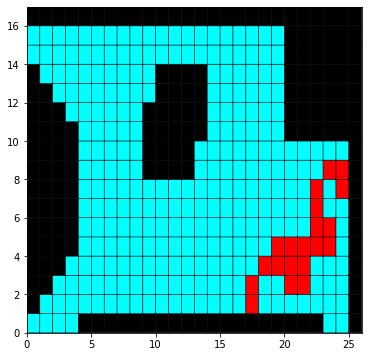

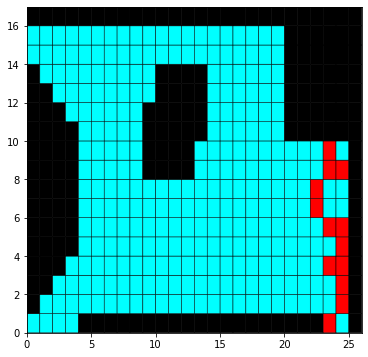

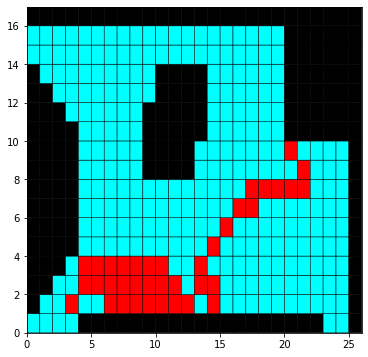

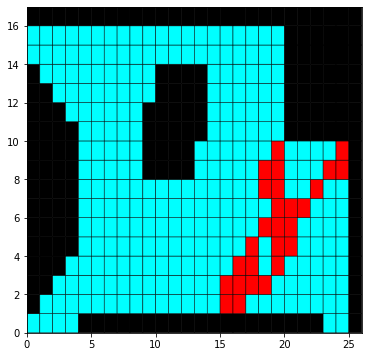

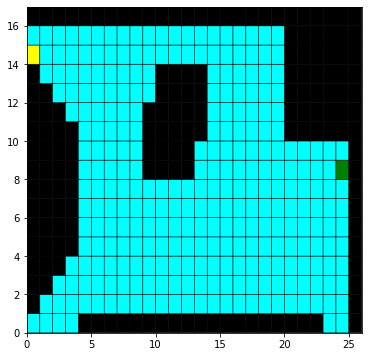

In [16]:
# ok so, the last two I'm going to do in a new cell bc nicer that way
# nothing has changed so I'm removing most the comments and only
# commenting on what has actually changed
# only 4 training epochs, supposed to do 2 but I wanna see 4
for training_epoch in range(4):
    state = states[np.random.choice(len(states))]
    while state in walls:
        state = states[np.random.choice(len(states))]
    # this is the path we took this epoch
    final_path = [state]
    for max_actions in range(100):
        if state == macro_goal:
            break
        max_q = float('-inf')
        best_action = None
        for action in actions(state):
            if Q[state][action] > max_q:
                max_q = Q[state][action]
                best_action = action
        if np.random.choice([0,1], p=[.8,.2]) == 1:
            best_action = actions(state)[np.random.choice(len(actions(state)))]
        next_state = transition(state, best_action)
        max_next_q = float('-inf')
        for action in actions(next_state):
            if Q[next_state][action] > max_next_q:
                max_next_q = Q[next_state][action]
        #if next_state == macro_goal:
            #print(max_next_q)
        alpha = 1
        curQ = Q[state][best_action]
        Q[state][best_action] = curQ + alpha*(reward(state) + 0.99*max_next_q - curQ)
        #print(Q[state][best_action])
        state = next_state
        # add this state to our path
        final_path.append(state)
    # we finished the epoch so graph our path using maze from earlier
    # haven't changed anything so taking out comments so it's less long and messy
    maze = [[0 for i in range(26)] for j in range(17)]
    for x in range(len(maze)):
        for y in range(len(maze[x])):
            maze[x][y] = 0
    for cord in final_path:
        maze[cord[1]-1][cord[0]-1] = 1
    for cord in walls:
        maze[cord[1]-1][cord[0]-1] = 2
    cmap = colors.ListedColormap(['Cyan', 'Red', 'Black'])
    plt.figure(figsize=(6,6))
    plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=0.5)
    plt.show()
# the original without the path for comparison
maze = [[0 for i in range(26)] for j in range(17)]
for x in range(len(maze)):
    for y in range(len(maze[x])):
        maze[x][y] = 0
for cord in walls:
    maze[cord[1]-1][cord[0]-1] = 1
maze[macro_start[1]-1][macro_start[0]-1] = 2
maze[macro_goal[1]-1][macro_goal[0]-1] = 3
cmap = colors.ListedColormap(['Cyan', 'Black', 'Yellow', 'Green'])
plt.figure(figsize=(6,6))
plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=0.5)
plt.show()    
#print(Q[macro_goal])

#### Part D:

As in part 2D, make a figure depicting the optimal policy at each location.  Does your agent actually try to avoid the ice, compared to how it behaved in the MDP in Part 2?

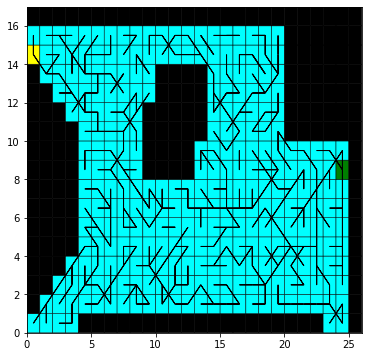

In [17]:
# another maze, same as 2D mostly
maze = [[0 for i in range(26)] for j in range(17)]
# everything is 0 to start
for x in range(len(maze)):
    for y in range(len(maze[x])):
        maze[x][y] = 0
# do walls last, if our path is suddenly missing
# then we know we tried to go through walls and failed somehow
for cord in walls:
    maze[cord[1]-1][cord[0]-1] = 1

# add our start and end bc cool
maze[macro_start[1]-1][macro_start[0]-1] = 2
maze[macro_goal[1]-1][macro_goal[0]-1] = 3
cmap = colors.ListedColormap(['Cyan', 'Black', 'Yellow', 'Green'])
plt.figure(figsize=(6,6))
plt.pcolor(maze[::], cmap=cmap, edgecolors='k', linewidths=0.5)
# iterate through the states in Q
for s in Q.keys():
    if not s == macro_goal:
        # find the max in this state and that's our policy
        best = float('-inf')
        act = ''
        for a in Q[s].keys():
            if Q[s][a] > best:
                best = Q[s][a]
                act = a
        if act == 'NE':
            plt.arrow(s[0]-0.5, s[1]-0.5, 1, 1)
        if act == 'NW':
            plt.arrow(s[0]-0.5, s[1]-0.5, -1, 1)
        if act == 'SE':
            plt.arrow(s[0]-0.5, s[1]-0.5, 1, -1)
        if act == 'SW':
            plt.arrow(s[0]-0.5, s[1]-0.5, -1, -1)
        if act == 'N':
            plt.arrow(s[0]-0.5, s[1]-0.5, 0, 1)
        if act == 'W':
            plt.arrow(s[0]-0.5, s[1]-0.5, -1, 0)
        if act == 'S':
            plt.arrow(s[0]-0.5, s[1]-0.5, 0, -1)
        if act == 'E':
            plt.arrow(s[0]-0.5, s[1]-0.5, 1, 0)
plt.show() 

It seems to me like there are a lot of areas that don't understand there is a goal. I've troubleshooted a lot and I don't really get why. Apparently the goal just isn't appealing which doesn't make any sense to me. It gets stuck in so many places though which I assume is because the goal state isn't propogating well. 